In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, roc_curve, auc

from utils.helper import load_and_summarize, scale_dataframe, split_data

In [2]:
df_liver_raw = load_and_summarize('CSV Files/liver_patient.csv')

--- Loading liver_patient.csv ---
First 5 rows:
   Age  Gender  Total_Bilirubin  Direct_Bilirubin  Alkaline_Phosphotase  \
0   65  Female              0.7               0.1                   187   
1   62    Male             10.9               5.5                   699   
2   62    Male              7.3               4.1                   490   
3   58    Male              1.0               0.4                   182   
4   72    Male              3.9               2.0                   195   

   Alamine_Aminotransferase  Aspartate_Aminotransferase  Total_Protiens  \
0                        16                          18             6.8   
1                        64                         100             7.5   
2                        60                          68             7.0   
3                        14                          20             6.8   
4                        27                          59             7.3   

   Albumin  Albumin_and_Globulin_Ratio  Dataset  


In [3]:
df_liver = df_liver_raw.drop('Gender', axis=1)
df_liver.dropna(inplace=True)
df_liver['Dataset'] = df_liver['Dataset'].replace(2, 0) # Map target to 0/1
df_liver_scaled = scale_dataframe(df_liver)

In [4]:
X_train_c, X_test_c, y_train_c, y_test_c =split_data(df_liver_scaled, 'Dataset')
print("\nLiver patient data prepared for classification.")


Liver patient data prepared for classification.


## Baseline Model (Decision Tree)

In [5]:
baseline_tree = DecisionTreeClassifier(random_state=42)
baseline_tree.fit(X_train_c, y_train_c)
y_pred_baseline = baseline_tree.predict(X_test_c)
baseline_accuracy = accuracy_score(y_test_c, y_pred_baseline)
print(f"Baseline Decision Tree Accuracy: {baseline_accuracy:.4f}")

Baseline Decision Tree Accuracy: 0.6466


## Gradient Boosting Classifier (with Hyperparameter Tuning) 

In [6]:
param_grid_gbc = {
        'n_estimators': [50, 100, 150],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [1, 2, 3]
}

grid_search_gbc = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=0),
    param_grid=param_grid_gbc,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

grid_search_gbc.fit(X_train_c, y_train_c)

print(f"\nBest Parameters found: {grid_search_gbc.best_params_}")


Best Parameters found: {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 50}


## Evaluate the Tuned Model 

In [7]:
best_gbc = grid_search_gbc.best_estimator_
y_pred_gbc = best_gbc.predict(X_test_c)
best_accuracy = accuracy_score(y_test_c, y_pred_gbc)
print(f"Best Gradient Boosting Classifier Accuracy after tuning: {best_accuracy:.4f}")

Best Gradient Boosting Classifier Accuracy after tuning: 0.6379


# Visualization 1 - Model Accuracy Comparison

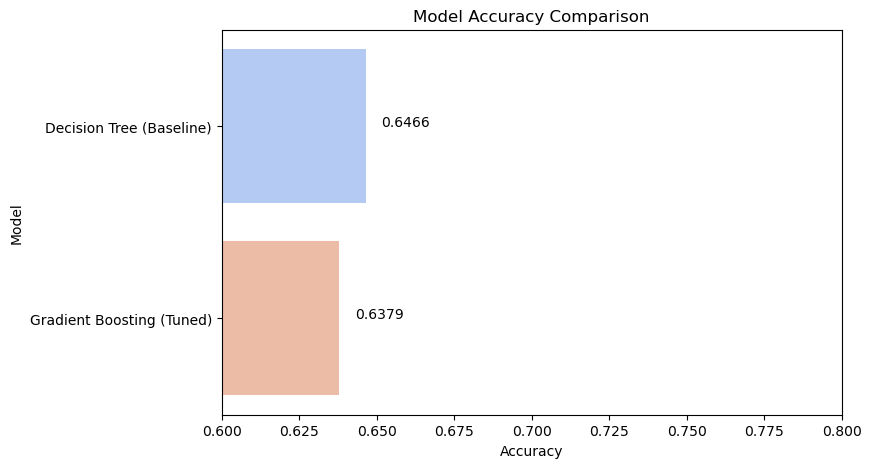

In [8]:
accuracies = {
    "Decision Tree (Baseline)": baseline_accuracy,
    "Gradient Boosting (Tuned)": best_accuracy
}
df_acc = pd.DataFrame(accuracies.items(), columns=['Model', 'Accuracy'])

plt.figure(figsize=(8, 5))
sns.barplot(x='Accuracy', y='Model', data=df_acc, palette='coolwarm', hue='Model', legend=False)
plt.xlim(0.6, 0.8)
plt.title('Model Accuracy Comparison')
for index, row in df_acc.iterrows():
    plt.text(row.Accuracy + 0.005, index, f'{row.Accuracy:.4f}', color='black', ha="left")
plt.show()

# Visualization 2 - Confusion Matrix for Best Model

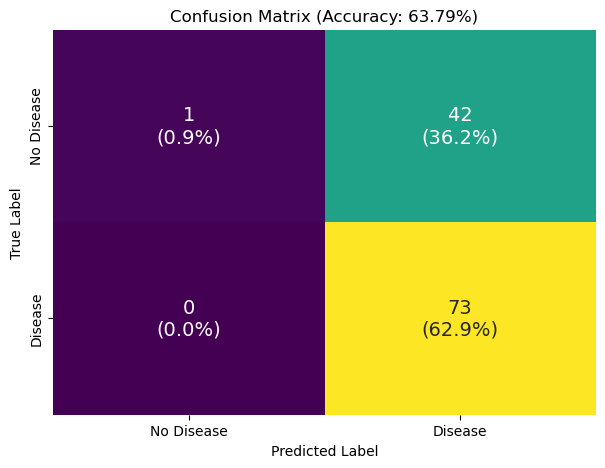

In [9]:
cm = confusion_matrix(y_test_c, y_pred_gbc)
cm_percent = cm / np.sum(cm)
labels = (
    np.asarray([f"{count}\n({percent:.1%})" for count, percent in zip(cm.flatten(), cm_percent.flatten())])
).reshape(2, 2)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=labels, fmt="", cmap="viridis", cbar=False, annot_kws={"size": 14})
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix (Accuracy: {best_accuracy:.2%})")
plt.xticks(ticks=[0.5, 1.5], labels=["No Disease", "Disease"])
plt.yticks(ticks=[0.5, 1.5], labels=["No Disease", "Disease"], va="center")
plt.show()

# Visualization 3 - ROC Curve and AUC Score

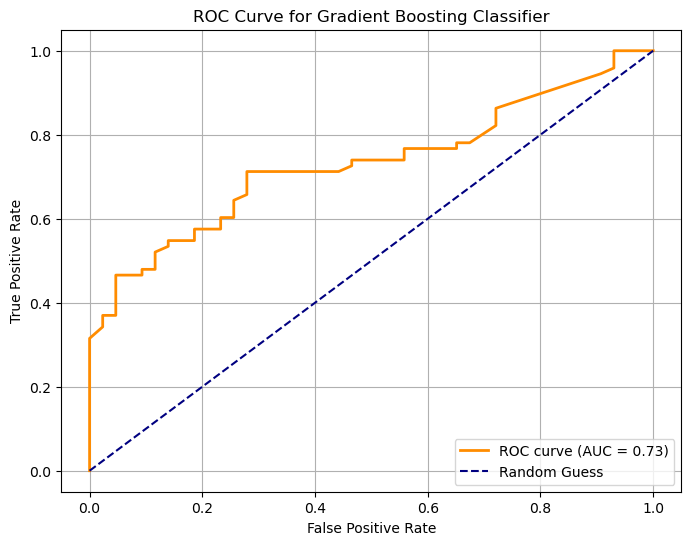

In [10]:
y_pred_proba_gbc = best_gbc.predict_proba(X_test_c)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_c, y_pred_proba_gbc)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Gradient Boosting Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()